# Regularization and Evaluation of Neural Networks

In [1]:
from sklearn.datasets import load_sample_images
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns

import tensorflow
tensorflow.random.set_seed(42)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.confusion import plot_confusion_matrix
    
%load_ext autoreload
%autoreload 2

## Learning Objectives

- use `keras` to code up a neural network model;
- explain dropout and early stopping as distinctive forms of regularization in neural networks;
- use wrappers inside `keras` to make models that can jibe with `sklearn`.

### From last time

In [2]:
digits = load_digits()
X = digits.data.astype('float32')
y = digits.target.astype('float32')

y_binary = y % 2

In [3]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X, y_binary, epochs=50, batch_size=10)

Epoch 1/50
180/180 [==============================] - 0s 772us/step - loss: 0.4896 - accuracy: 0.8002
Epoch 2/50
180/180 [==============================] - 0s 706us/step - loss: 0.2444 - accuracy: 0.8987
Epoch 3/50
180/180 [==============================] - 0s 772us/step - loss: 0.1972 - accuracy: 0.9188
Epoch 4/50
180/180 [==============================] - 0s 662us/step - loss: 0.1717 - accuracy: 0.9282
Epoch 5/50
180/180 [==============================] - 0s 687us/step - loss: 0.1465 - accuracy: 0.9427
Epoch 6/50
180/180 [==============================] - 0s 708us/step - loss: 0.1261 - accuracy: 0.9482
Epoch 7/50
180/180 [==============================] - 0s 655us/step - loss: 0.1107 - accuracy: 0.9588
Epoch 8/50
180/180 [==============================] - 0s 657us/step - loss: 0.1003 - accuracy: 0.9616
Epoch 9/50
180/180 [==============================] - 0s 752us/step - loss: 0.0949 - accuracy: 0.9649
Epoch 10/50
180/180 [==============================] - 0s 661us/step - loss: 0.084

### Things to know:

- The data and labels in `fit()` need to be numpy arrays, not `pandas` dfs.
- Scaling your data will have a large impact on your model.
   > For our traditional input features, we would use a scaler object. For images, as long as the minimum value is 0, we can simply divide through by the maximum pixel intensity.

#### Getting data ready for modeling

**Preprocessing**:

- use train_test_split to create X_train, y_train, X_test, and y_test
- Split training data into pure_train and validation sets.
- Scale the pixel intensity to a value between 0 and 1.

Scaling our input variables will help speed up our neural network.

Since our minimum intensity is 0, we can normalize the inputs by dividing each value by the max value (16).

In [4]:
X_train, X_test, y_train, y_test =\
    train_test_split(X, y_binary, random_state=42, test_size=0.2)

X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train, random_state=42, test_size=0.2)

X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

In [5]:
X_pure_train

array([[0.    , 0.    , 0.    , ..., 0.875 , 0.    , 0.    ],
       [0.    , 0.    , 0.125 , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       ...,
       [0.    , 0.    , 0.375 , ..., 0.1875, 0.    , 0.    ],
       [0.    , 0.    , 0.625 , ..., 0.8125, 1.    , 0.5   ],
       [0.    , 0.    , 0.25  , ..., 0.0625, 0.    , 0.    ]],
      dtype=float32)

### Sigmoid 

For activation, let's start with the familiar sigmoid function, and see how it performs.

In [6]:
model = Sequential()
# We will start with our trusty sigmoid function.
# What does input dimension correspond to?
model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD' ,
              # We use binary_crossentropy for a binary loss function
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output. To see
# only the metrics at the end of each epoch, set verbose=2.
results = model.fit(X_pure_train, y_pure_train, epochs=10, batch_size=100, verbose=1)

Epoch 1/10
12/12 [==============================] - 0s 724us/step - loss: 0.7202 - accuracy: 0.5039
Epoch 2/10
12/12 [==============================] - 0s 915us/step - loss: 0.7141 - accuracy: 0.5039
Epoch 3/10
12/12 [==============================] - 0s 754us/step - loss: 0.7090 - accuracy: 0.5039
Epoch 4/10
12/12 [==============================] - 0s 773us/step - loss: 0.7049 - accuracy: 0.5039
Epoch 5/10
12/12 [==============================] - 0s 812us/step - loss: 0.7015 - accuracy: 0.5039
Epoch 6/10
12/12 [==============================] - 0s 798us/step - loss: 0.6989 - accuracy: 0.5039
Epoch 7/10
12/12 [==============================] - 0s 797us/step - loss: 0.6965 - accuracy: 0.5039
Epoch 8/10
12/12 [==============================] - 0s 823us/step - loss: 0.6947 - accuracy: 0.5039
Epoch 9/10
12/12 [==============================] - 0s 663us/step - loss: 0.6932 - accuracy: 0.5039
Epoch 10/10
12/12 [==============================] - 0s 923us/step - loss: 0.6920 - accuracy: 0.5039

We can access the history of our model via `results.history`.
Use __dict__ to take a tour.

In [7]:
# dict
results.__dict__

{'validation_data': None,
 'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x29fc225ad60>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [0.7202345728874207,
   0.7140858769416809,
   0.709007978439331,
   0.7048927545547485,
   0.7015445232391357,
   0.6989108324050903,
   0.6965351104736328,
   0.6947341561317444,
   0.6931974291801453,
   0.6919931173324585],
  'accuracy': [0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566]},
 'params': {'verbose': 1, 'epochs': 10, 'steps': 12},
 'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}

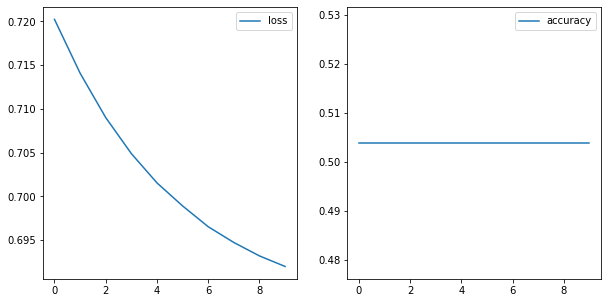

In [8]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy');

We have two plots above both relating to the quality of our model.  The left-hand plot is our loss. It uses the probabilities associated with our predictions to judge how well our prediction fits reality. We want it to decrease as far as possible.

The accuracy judges how well the predictions are after applying the threshold at the output layer.  We want accuracy to increase.

If we look at our loss, it is still decreasing. That is a signal that our model is **still learning**. If our model is still learning, we can allow it to get better by turning a few dials.

Let's:
- increase the number of epochs;
- change sigmoid activation in the hidden layers to ReLU; and
- decrease the batch size.

## Basic Model Tuning

### Increase Epochs

In [9]:
model = Sequential()
model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output.
# increase epochs

results = model.fit(X_pure_train, y_pure_train, epochs=100, batch_size=100, verbose=1)

Epoch 1/100
12/12 [==============================] - 0s 1ms/step - loss: 0.7416 - accuracy: 0.4961
Epoch 2/100
12/12 [==============================] - 0s 1ms/step - loss: 0.7305 - accuracy: 0.4961
Epoch 3/100
12/12 [==============================] - 0s 1ms/step - loss: 0.7218 - accuracy: 0.4961
Epoch 4/100
12/12 [==============================] - 0s 773us/step - loss: 0.7149 - accuracy: 0.4961
Epoch 5/100
12/12 [==============================] - 0s 927us/step - loss: 0.7094 - accuracy: 0.4961
Epoch 6/100
12/12 [==============================] - 0s 831us/step - loss: 0.7050 - accuracy: 0.4961
Epoch 7/100
12/12 [==============================] - 0s 970us/step - loss: 0.7018 - accuracy: 0.4961
Epoch 8/100
12/12 [==============================] - 0s 885us/step - loss: 0.6991 - accuracy: 0.4961
Epoch 9/100
12/12 [==============================] - 0s 881us/step - loss: 0.6969 - accuracy: 0.4961
Epoch 10/100
12/12 [==============================] - 0s 1ms/step - loss: 0.6951 - accuracy: 0.49

12/12 [==============================] - 0s 748us/step - loss: 0.6827 - accuracy: 0.6466
Epoch 82/100
12/12 [==============================] - 0s 691us/step - loss: 0.6826 - accuracy: 0.6667
Epoch 83/100
12/12 [==============================] - 0s 775us/step - loss: 0.6825 - accuracy: 0.6641
Epoch 84/100
12/12 [==============================] - 0s 831us/step - loss: 0.6824 - accuracy: 0.6884
Epoch 85/100
12/12 [==============================] - 0s 715us/step - loss: 0.6823 - accuracy: 0.6701
Epoch 86/100
12/12 [==============================] - 0s 836us/step - loss: 0.6822 - accuracy: 0.6675
Epoch 87/100
12/12 [==============================] - 0s 748us/step - loss: 0.6821 - accuracy: 0.6684
Epoch 88/100
12/12 [==============================] - 0s 718us/step - loss: 0.6820 - accuracy: 0.6789
Epoch 89/100
12/12 [==============================] - 0s 748us/step - loss: 0.6818 - accuracy: 0.6562
Epoch 90/100
12/12 [==============================] - 0s 964us/step - loss: 0.6817 - accuracy: 

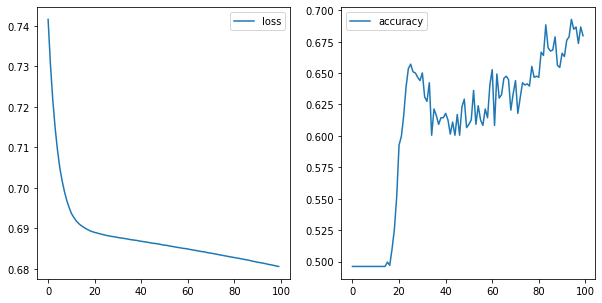

In [10]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy')
ax1.legend();

### Decrease Batch Size

In [11]:
model = Sequential()

model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# decrease batch size
results = model.fit(X_pure_train, y_pure_train, epochs=10, batch_size=10, verbose=1)

Epoch 1/10
115/115 [==============================] - 0s 852us/step - loss: 0.7210 - accuracy: 0.5039
Epoch 2/10
115/115 [==============================] - 0s 721us/step - loss: 0.6973 - accuracy: 0.5039
Epoch 3/10
115/115 [==============================] - 0s 723us/step - loss: 0.6930 - accuracy: 0.5083
Epoch 4/10
115/115 [==============================] - 0s 717us/step - loss: 0.6914 - accuracy: 0.5326
Epoch 5/10
115/115 [==============================] - 0s 747us/step - loss: 0.6903 - accuracy: 0.5683
Epoch 6/10
115/115 [==============================] - 0s 727us/step - loss: 0.6891 - accuracy: 0.5413
Epoch 7/10
115/115 [==============================] - 0s 795us/step - loss: 0.6879 - accuracy: 0.6527
Epoch 8/10
115/115 [==============================] - 0s 740us/step - loss: 0.6866 - accuracy: 0.5909
Epoch 9/10
115/115 [==============================] - 0s 918us/step - loss: 0.6854 - accuracy: 0.6997
Epoch 10/10
115/115 [==============================] - 0s 873us/step - loss: 0.684

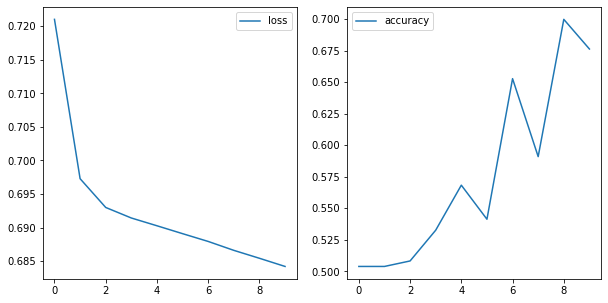

In [12]:
relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy')
ax1.legend();

### Both

In [13]:
model = Sequential()

model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# increase epochs decrease batch size
results = model.fit(X_pure_train, y_pure_train, epochs=100, batch_size=10, verbose=1)

Epoch 1/100
115/115 [==============================] - 0s 612us/step - loss: 0.6946 - accuracy: 0.5039
Epoch 2/100
115/115 [==============================] - 0s 639us/step - loss: 0.6938 - accuracy: 0.5117
Epoch 3/100
115/115 [==============================] - 0s 665us/step - loss: 0.6933 - accuracy: 0.5100
Epoch 4/100
115/115 [==============================] - 0s 683us/step - loss: 0.6929 - accuracy: 0.5057
Epoch 5/100
115/115 [==============================] - 0s 698us/step - loss: 0.6926 - accuracy: 0.5431
Epoch 6/100
115/115 [==============================] - 0s 718us/step - loss: 0.6923 - accuracy: 0.5117
Epoch 7/100
115/115 [==============================] - 0s 686us/step - loss: 0.6920 - accuracy: 0.5509
Epoch 8/100
115/115 [==============================] - 0s 715us/step - loss: 0.6916 - accuracy: 0.5335
Epoch 9/100
115/115 [==============================] - 0s 686us/step - loss: 0.6913 - accuracy: 0.5683
Epoch 10/100
115/115 [==============================] - 0s 713us/step - l

115/115 [==============================] - 0s 616us/step - loss: 0.4204 - accuracy: 0.8573
Epoch 80/100
115/115 [==============================] - 0s 588us/step - loss: 0.4120 - accuracy: 0.8581
Epoch 81/100
115/115 [==============================] - 0s 579us/step - loss: 0.4039 - accuracy: 0.8590
Epoch 82/100
115/115 [==============================] - 0s 573us/step - loss: 0.3963 - accuracy: 0.8590
Epoch 83/100
115/115 [==============================] - 0s 599us/step - loss: 0.3887 - accuracy: 0.8642
Epoch 84/100
115/115 [==============================] - 0s 570us/step - loss: 0.3818 - accuracy: 0.8660
Epoch 85/100
115/115 [==============================] - 0s 589us/step - loss: 0.3748 - accuracy: 0.8668
Epoch 86/100
115/115 [==============================] - 0s 606us/step - loss: 0.3687 - accuracy: 0.8686
Epoch 87/100
115/115 [==============================] - 0s 605us/step - loss: 0.3624 - accuracy: 0.8677
Epoch 88/100
115/115 [==============================] - 0s 758us/step - loss:

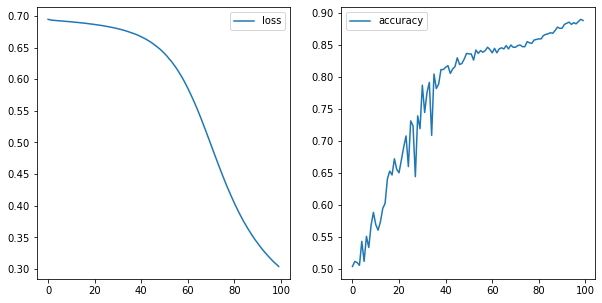

In [14]:
relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy')
ax1.legend();

### Use Relu

In [15]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output.
# increase epochs, decrease batchsize

results = model.fit(X_pure_train, y_pure_train, epochs=10, batch_size=100, verbose=0)


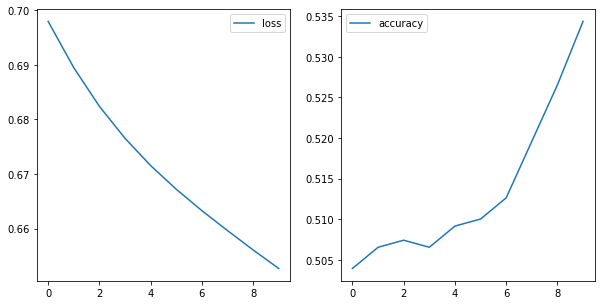

In [16]:
relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy')
ax1.legend();

### All of it (epochs, batch, relu)

In [17]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output.
# increase epochs
results = model.fit(X_pure_train, y_pure_train, epochs=100, batch_size=100, verbose=0)




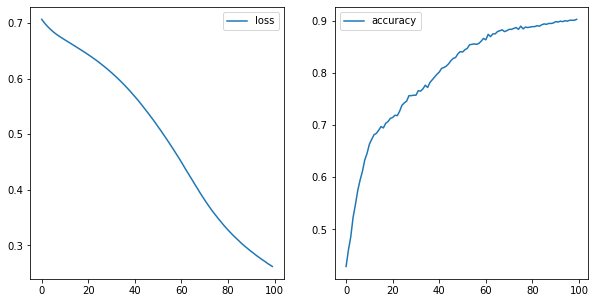

In [18]:
relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy')
ax1.legend();

### Side note: learning rate

If we increase the learning rate to a very high number, we see that our model overshoots the minimum, and starts bouncing all around.

Epoch 1/30
115/115 [==============================] - 0s 745us/step - loss: 1.0947 - accuracy: 0.5004
Epoch 2/30
115/115 [==============================] - 0s 693us/step - loss: 0.9463 - accuracy: 0.5283
Epoch 3/30
115/115 [==============================] - 0s 801us/step - loss: 0.9962 - accuracy: 0.4900
Epoch 4/30
115/115 [==============================] - 0s 759us/step - loss: 1.1203 - accuracy: 0.4639
Epoch 5/30
115/115 [==============================] - 0s 766us/step - loss: 0.9059 - accuracy: 0.5239
Epoch 6/30
115/115 [==============================] - 0s 928us/step - loss: 1.0217 - accuracy: 0.4961
Epoch 7/30
115/115 [==============================] - 0s 929us/step - loss: 1.0198 - accuracy: 0.4961
Epoch 8/30
115/115 [==============================] - 0s 768us/step - loss: 0.9113 - accuracy: 0.5309
Epoch 9/30
115/115 [==============================] - 0s 807us/step - loss: 1.0312 - accuracy: 0.4865
Epoch 10/30
115/115 [==============================] - 0s 781us/step - loss: 1.094

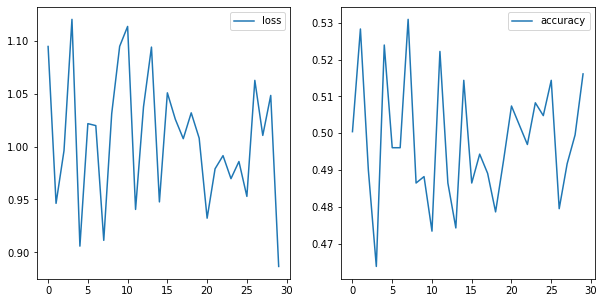

In [19]:
model = Sequential()

sgd = SGD(lr=9)


model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=sgd,
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                    epochs=30, batch_size=10, verbose=1)

relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy')
ax1.legend();


### Exercise

We have been looking only at our training set. Let's add in our validation set to the picture. Check the docstring for the `.fit()` method and add in our validation data.

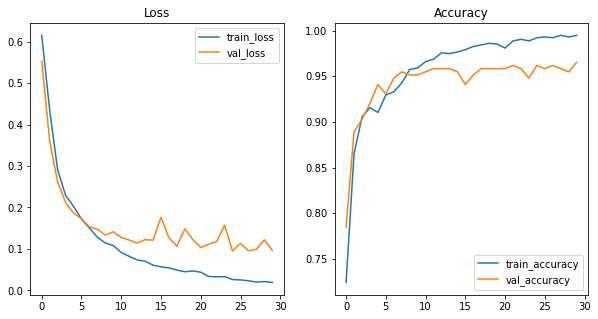

In [20]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


## YOUR CODE HERE
results = model.fit(X_pure_train, 
                    y_pure_train, 
                    epochs=30, 
                    batch_size=10, 
                    validation_data=(X_val, y_val), 
                    verbose=0)


train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

In [21]:
results.history['val_accuracy'][-1]

0.9652777910232544

## Connecting with `sklearn`

The `keras.wrappers` submodule means that we can turn `keras` models into estimators that `sklearn` tools will recognize.

In [22]:
# # This will throw an error.

# cross_val_score(model, X_pure_train, y_pure_train)

In [23]:
def build_model():
    model = Sequential()
    model.add(Dense(12, activation='relu', input_dim=64))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [24]:
keras_model = scikit_learn.KerasClassifier(build_model,
                                          epochs=10,
                                          batch_size=32,
                                          verbose=2)

In [25]:
type(keras_model)

tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier

In [26]:
cross_val_score(keras_model, X_pure_train, y_pure_train)

Epoch 1/10
29/29 - 0s - loss: 0.6954 - accuracy: 0.4929
Epoch 2/10
29/29 - 0s - loss: 0.6686 - accuracy: 0.4962
Epoch 3/10
29/29 - 0s - loss: 0.6266 - accuracy: 0.5158
Epoch 4/10
29/29 - 0s - loss: 0.5844 - accuracy: 0.6126
Epoch 5/10
29/29 - 0s - loss: 0.5455 - accuracy: 0.7606
Epoch 6/10
29/29 - 0s - loss: 0.5107 - accuracy: 0.8052
Epoch 7/10
29/29 - 0s - loss: 0.4812 - accuracy: 0.8477
Epoch 8/10
29/29 - 0s - loss: 0.4570 - accuracy: 0.8694
Epoch 9/10
29/29 - 0s - loss: 0.4363 - accuracy: 0.8825
Epoch 10/10
29/29 - 0s - loss: 0.4208 - accuracy: 0.8901
8/8 - 0s - loss: 0.3885 - accuracy: 0.8870
Epoch 1/10
29/29 - 0s - loss: 0.6610 - accuracy: 0.6366
Epoch 2/10
29/29 - 0s - loss: 0.5890 - accuracy: 0.7726
Epoch 3/10
29/29 - 0s - loss: 0.5086 - accuracy: 0.8313
Epoch 4/10
29/29 - 0s - loss: 0.4272 - accuracy: 0.8727
Epoch 5/10
29/29 - 0s - loss: 0.3582 - accuracy: 0.8923
Epoch 6/10
29/29 - 0s - loss: 0.3104 - accuracy: 0.8945
Epoch 7/10
29/29 - 0s - loss: 0.2725 - accuracy: 0.9097
Epoc

array([0.88695651, 0.93043476, 0.93478262, 0.93913043, 0.51528382])

## [Regularization](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/Regularizer)

Does regularization make sense in the context of neural networks? <br/>

Yes! We still have all of the salient ingredients: a loss function, overfitting vs. underfitting, and coefficients (weights) that could get too large.

But there are now a few different flavors besides L1 and L2 regularization. (Note that L1 regularization is not common in the context of  neural networks.)

We'll add a few more layers to give regularization a better chance of making a difference!

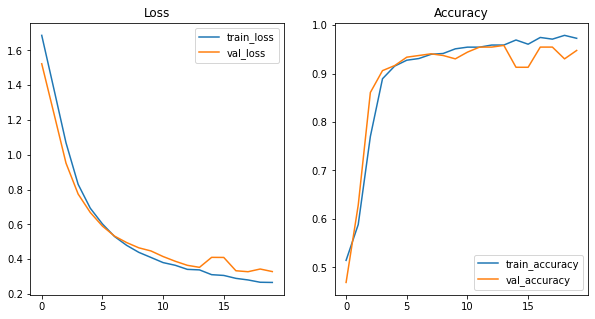

In [27]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))

# We can add L2 (or L1) regularization right into
# the layer with the kernel_regularizer parameter.

model.add(Dense(20, activation='relu',kernel_regularizer=l2(l=0.05)))

# Note that there is also a bias_regularizer,
# but this tends to have less effect.

model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

Adding L2 to multiple layers:

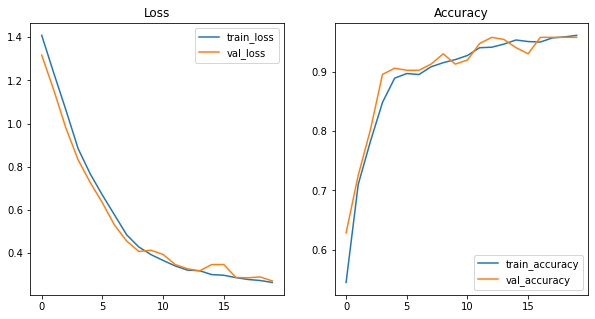

In [28]:
model = Sequential()
model.add(Dense(30, activation='relu',
                input_dim=64))
model.add(Dense(20, activation='relu',
                kernel_regularizer=l2(l=0.01)))

model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l=0.01)))
model.add(Dense(8, activation='relu',
                kernel_regularizer=l2(l=0.01)))
model.add(Dense(4, activation='relu',
                kernel_regularizer=l2(l=0.01)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

### Dropout

We can also specify a dropout layer in keras, which randomly shuts off different nodes during training. This can help to prevent overfitting.

![drop_out](images/drop_out.png)

### Exercise

To add dropout to a `keras` network, simply add it as though it were a layer. It will apply to the immediately preceding layer.

Add Dropout to one or more layers below.

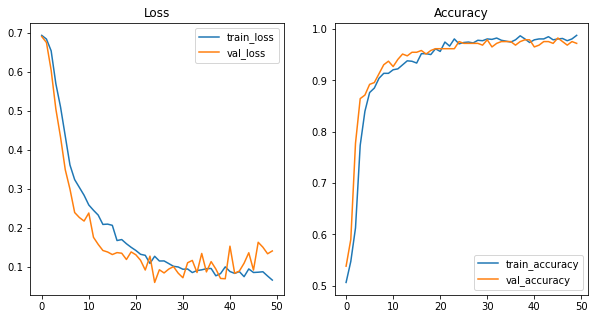

In [29]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=50,
                    batch_size= 32, verbose=0,
                    validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

In [30]:
results.history['val_accuracy'][-1]

0.9722222089767456

### Early Stopping

We can also tell our neural network to stop once it stops realizing any gain.

Here we tell it to stop once the a very small positive change in the validation loss occurs:

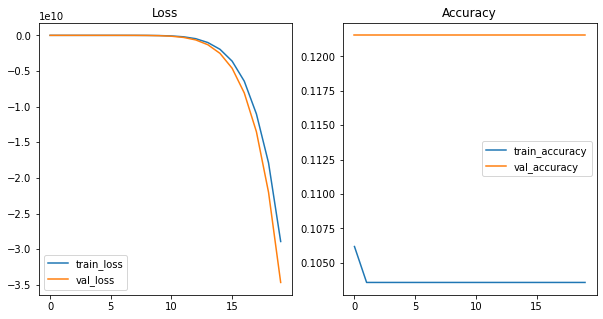

In [46]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=1e-8,
                           verbose=1,
                           mode='min')

# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

### Exercise

That probably stopped too early. We can specify the number of epochs in which it doesn't see decrease in the loss with the `patience` parameter. Modify the code below to include an Early Stop with a patience of 5 epochs.

In [ ]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object


# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=50, batch_size= 32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

In [ ]:
results.history['val_accuracy'][-1]

## Multiclass Classification and Softmax

Now let's return to the problem of predicting digits 0 through 9.

In [47]:
digits = load_digits()
X = digits.data
y = digits.target

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)
X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train,
                     random_state=42, test_size=0.2)
X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

For a multiclass output, our neural net expects our target to be in a certain form.

In [49]:
ohe = OneHotEncoder(sparse=False)
y_pure_train = ohe.fit_transform(y_pure_train.reshape(-1,1))
y_val = ohe.transform(y_val.reshape(-1,1))
y_test = ohe.transform(y_test.reshape(-1,1))

In [50]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [51]:
y_test.shape

(360, 10)

In [52]:
# Model from above, but now with ten output neurons:

model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                   epochs=50, batch_size=10,
                   validation_data=(X_val, y_val))

Epoch 1/50
115/115 [==============================] - 0s 2ms/step - loss: 2.2042 - accuracy: 0.1941 - val_loss: 2.0113 - val_accuracy: 0.3403
Epoch 2/50
115/115 [==============================] - 0s 828us/step - loss: 1.8705 - accuracy: 0.3664 - val_loss: 1.6787 - val_accuracy: 0.4757
Epoch 3/50
115/115 [==============================] - 0s 831us/step - loss: 1.5638 - accuracy: 0.4970 - val_loss: 1.4022 - val_accuracy: 0.5174
Epoch 4/50
115/115 [==============================] - 0s 897us/step - loss: 1.2825 - accuracy: 0.5640 - val_loss: 1.1285 - val_accuracy: 0.6493
Epoch 5/50
115/115 [==============================] - 0s 877us/step - loss: 0.9875 - accuracy: 0.7093 - val_loss: 0.8704 - val_accuracy: 0.7569
Epoch 6/50
115/115 [==============================] - 0s 929us/step - loss: 0.7662 - accuracy: 0.7937 - val_loss: 0.7052 - val_accuracy: 0.8194
Epoch 7/50
115/115 [==============================] - 0s 958us/step - loss: 0.6261 - accuracy: 0.8390 - val_loss: 0.5837 - val_accuracy: 0

$$\large \text{Softmax}(x_{i}) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}$$

The sofmax function outputs a number between 0 and 1 for each of our classes.  All of the probabilities of the classes sum up to 1.

The number of nodes in our output layer equals the number of categories in our dataset.

We also need a new loss function: **categorical crossentropy**, which calculates a separate loss for each label and then sums the results.

In [53]:
history = results.history
training_loss = history['loss']
val_loss = history['val_loss']
training_accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

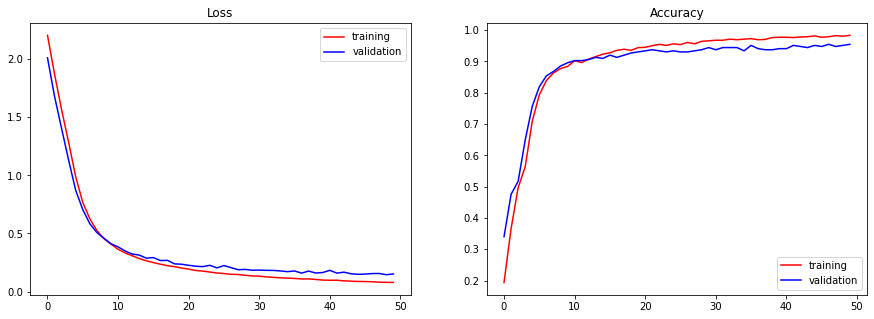

In [57]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))


sns.lineplot(x=list(range(len(training_loss))),
             y=training_loss, color='r', label='training', ax=ax1)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_loss, color='b', label='validation', ax=ax1)
sns.lineplot(x=list(range(len(training_loss))),
             y=training_accuracy, color='r', label='training',ax=ax2)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_accuracy, color='b', label='validation',ax=ax2)

ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

In [ ]:
history['val_accuracy'][-1]

In [ ]:
history['val_accuracy'][-1]

In [ ]:
history['val_accuracy'][-1]

In [ ]:
history['val_accuracy'][-1]

Wow, look at that performance!  

That is great, but remember, we were dealing with simple black and white images.  With color, our basic neural net will have less success.

We will explore more advanced tools in the coming days.
